In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from scipy import stats
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import GP
from jaxbo.utils import normalize

import jaxbo.acquisitions as acquisitions
import jaxbo.utils as utils
from jaxbo.input_priors import uniform_prior

from sklearn import mixture
from pyDOE import lhs

onp.random.seed(1234)


In [2]:
def wheel_function(x, y, delta_control):
    # define the control parameter
    reward0 = 0.2
    reward1 = 1.0
    reward2 = 0.1
    reward3 = 0.05
    reward4 = 0.0
    
    # the number of modes in this direction
    r = np.sqrt(x**2 + y**2)
    if r < delta_control:
        return reward0
    elif (x >= 0) & (y >= 0):
        return reward1
    elif (x >= 0) & (y <= 0):
        return reward2
    elif (x <= 0) & (y >= 0):
        return reward3
    else:
        return reward4
    

In [3]:
class run_simulations:
    # Initialize the class
    def __init__(self, data_test, xs_in, sigma_in, T_in, MC_samples_in, XX, YY, Y_data_plot, nn, delta_control):
        
        # Initialize the model
        self.Data = data_test
        self.N_dim = self.Data.shape[0]
        
        self.xs = xs_in
        self.xs_plot = onp.asarray(xs_in)
        self.sigma = sigma_in
        self.T = T_in
        self.MC_samples = MC_samples_in
        self.delta = 0.1
        self.jitter = 1e-8
        self.N_init = 3
        
        self.XX = XX
        self.YY = YY
        self.Y_data_plot = Y_data_plot
        self.nn = nn
        self.delta_control = delta_control
        
        # define GP model and JAX GP options
        self.dim = xs_in.shape[1]
        self.lb = 0.0*np.ones(self.dim)
        self.ub = 1.0*np.ones(self.dim)
        self.bounds = {'lb': self.lb, 'ub': self.ub}
        self.p_x = uniform_prior(self.lb, self.ub)
        self.options = {'kernel': 'RBF', 'input_prior': self.p_x}
        self.gp_model = GP(self.options)
        
        self.rng_key = random.PRNGKey(0)
        
        
    # Different types of acquisition functions
    def acquisition_functions(self, mu, std, y_sample, best, beta = 1.0, weights = 0, method = "LCB"):
        kappa = 2.0
        if method == "LCB":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], np.sqrt(beta))
        if method == "LCB_v":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], kappa)
        if method == "mean":
            return mu
        if method == "LW_LCB":
            return vmap(acquisitions.LW_LCB, in_axes=(0,0,0,None))(mu[:,None], std[:,None], weights[:,None], kappa)
        if method == "TS":
            return y_sample
        if method == "EI":
            return vmap(acquisitions.EI, in_axes=(0,0,None))(mu[:,None], std[:,None], best)
    
    
    def compute_weights(self, x):
        
        weights = utils.compute_w_gmm(x, **self.kwargs)
        self.weights = weights
        
        return weights
        
    def compute_beta(self, t):
        beta = 2 * np.log(t**2*np.pi**2/(6 * self.delta))
        beta = beta / 5.
        return beta

    def compute_mu_std_sample(self, X, y, X_star, rng_key, compute_weight = False):
        
        # Fetch normalized training data
        norm_batch, norm_const = normalize(X, y, self.bounds)

        # Train GP model
        opt_params = self.gp_model.train(norm_batch, rng_key, num_restarts = 10)
        
        # Define the dictionary to feed in the GP regression 
        self.kwargs = {'params': opt_params, 
                  'batch': norm_batch, 
                  'norm_const': norm_const, 
                  'bounds': self.bounds,
                  'rng_key': rng_key}
        
        if compute_weight:
            gmm_vars = self.gp_model.fit_gmm(**self.kwargs, num_comp = 4, N_samples = 10000)

            self.kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': self.bounds,
                  'gmm_vars': gmm_vars,
                  'rng_key': rng_key}

        # Draw posterior mean and std and a sample from posterior distribution 
        mu, std = self.gp_model.predict(X_star, **self.kwargs)
        y_sample = self.gp_model.draw_posterior_sample(X_star, **self.kwargs)
        
        mu, std = mu * norm_const['sigma_y'] + norm_const['mu_y'], std *norm_const['sigma_y']
        y_sample = y_sample * norm_const['sigma_y'] + norm_const['mu_y']
        
        return mu, std, y_sample
        
        
    def run_one_trial(self, sample_idx, method = "LCB"):
        
        # the testing data for the current MC trial
        data = self.Data[:,sample_idx]
        x_cand = self.xs
        
        # inital random observation
        idx_cand = np.arange(x_cand.shape[0])
        idx_valid_init = idx_cand[(np.sqrt(np.sum(x_cand**2, axis = 1)) <= self.delta_control)]
        idx_init = idx_valid_init[onp.random.randint(idx_valid_init.shape[0], size = self.N_init)]
        
        print(idx_init)
        #idx_init = list(onp.random.randint(self.N_dim, size = self.N_init)) 
        
        # check the shape (Y is vector not array)
        Y = data[idx_init] + onp.random.normal(0, self.sigma, self.N_init)
        X = x_cand[idx_init,:]
        
        regrets = []
        
        # get the best payoff
        index_best = np.argmin(data)
        Y_best = data[index_best]
        
        # start to record the regret
        regrets.append(abs(Y_best - np.min(Y)))
        
        rng_key = random.split(self.rng_key)[0]
        # start the active learning
        for t in range(1, self.T):

            # compute beta and modify correspondingly according to inital number of data
            beta = self.compute_beta(t + self.N_init - 1)
            
            #print("X, Y", X.shape, Y.shape, X, Y)
            
            if method == "LW_LCB":
                compute_weight = True
            else:
                compute_weight = False
            
            # compute GP posterior mean and std
            rng_key = random.split(rng_key)[0]
            mu, std, y_sample = self.compute_mu_std_sample(X, Y, self.xs, rng_key, compute_weight)
            
            # best for the EI if needed
            best = np.min(Y)
            
            # compute the weight for the LW-LCB if needed
            if method == "LW_LCB":
                weights = self.compute_weights(x_cand)
            else:
                weights = 0
                
            # compute acquisition function
            acquisition_fun = self.acquisition_functions(mu, std, y_sample, best, beta, weights, method)

            # find the index best location to explore 
            best_index = np.argmin(acquisition_fun)
            
            # find the best location to explore
            X_new = x_cand[best_index:best_index+1,:]
            
            # observe the noisy reward
            Y_new = data[best_index] + onp.random.normal(0, self.sigma, 1)
            
            #print(X.shape, Y.shape, X_new.shape, Y_new.shape)
            # update X and Y
            X = np.concatenate([X, X_new], axis = 0)
            Y = np.concatenate([Y, Y_new], axis = 0)
            
            regrets.append(abs(Y_best - Y_new[0]))
            #regrets.append(abs(Y_best - min(Y)))
            
            if t == self.T - 1 and method == "LW_LCB":
                
                weights_plot = griddata((self.xs_plot[:,0], self.xs_plot[:,1]), onp.asarray(weights).flatten(), (self.XX, self.YY), method='linear')

                plt.figure(t + sample_idx, figsize = (10, 5))
                plt.subplot(1, 2, 1)
                fig = plt.contourf(self.XX, self.YY, self.Y_data_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                
                
                plt.subplot(1, 2, 2)
                fig = plt.contourf(self.XX, self.YY, weights_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                plt.show()
                
            if method == "LW_LCB":
                continue
            else:
                weights_plot = None
            
        return regrets, X, weights_plot
        
    def train(self):
        
        regrets_LCB = []
        regrets_LCB_v = []
        regrets_mean = []
        regrets_TS = []
        regrets_EI = []
        regrets_LW_LCB = []
        
        X_LCB = []
        X_LCB_v = []
        X_mean = []
        X_TS = []
        X_EI = []
        X_LW_LCB = []
        
        Weights_LW_LCB = []


        for k in range(self.MC_samples):
            if k % 1 == 0:
                print(k)
            regrets, X, weights_plot = self.run_one_trial(k, method = "LW_LCB")
            regrets_LW_LCB.append(regrets)
            X_LW_LCB.append(X)
            Weights_LW_LCB.append(weights_plot)
            regrets, X, _ = self.run_one_trial(k, method = "LCB")
            regrets_LCB.append(regrets)
            X_LCB.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "LCB_v")
            regrets_LCB_v.append(regrets)
            X_LCB_v.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "mean")
            regrets_mean.append(regrets)
            X_mean.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "TS")
            regrets_TS.append(regrets)
            X_TS.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "EI")
            regrets_EI.append(regrets)
            X_EI.append(X)

            
            
        regrets_LCB = np.asarray(regrets_LCB)
        regrets_LCB_v = np.asarray(regrets_LCB_v)
        regrets_mean = np.asarray(regrets_mean)
        regrets_TS = np.asarray(regrets_TS)
        regrets_EI = np.asarray(regrets_EI)
        regrets_LW_LCB = np.asarray(regrets_LW_LCB)
        
        X_LCB = np.asarray(X_LCB)
        X_LCB_v = np.asarray(X_LCB_v)
        X_mean = np.asarray(X_mean)
        X_TS = np.asarray(X_TS)
        X_EI = np.asarray(X_EI)
        X_LW_LCB = np.asarray(X_LW_LCB)
        
        Weights_LW_LCB = np.asarray(Weights_LW_LCB)
        
        print(regrets_LCB.shape, regrets_LCB_v.shape, regrets_mean.shape, regrets_TS.shape, regrets_EI.shape, regrets_LW_LCB.shape, \
                X_LCB.shape, X_LCB_v.shape, X_mean.shape, X_TS.shape, X_EI.shape, X_LW_LCB.shape, Weights_LW_LCB.shape)
        
        return regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
                X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB
            



(2724, 100)


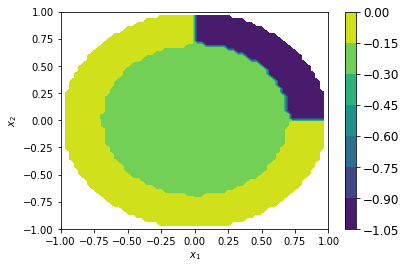

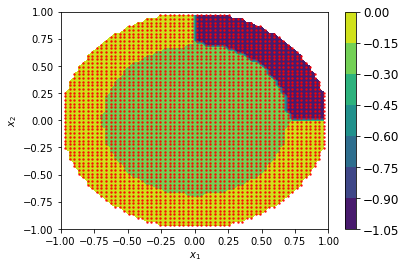

In [4]:
MC_samples = 100
nn = 60
delta_control = 0.7


# Locations for bandits
xx = onp.linspace(-1, 1, nn)
yy = onp.linspace(-1, 1, nn)
XX, YY = onp.meshgrid(xx, yy)
X_positions = onp.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)

# find the valid locations
R = onp.sqrt(X_positions[:,0]**2 + X_positions[:,1]**2)
X_positions = X_positions[R <= 1]

# Draw training data from functions
Y_data = onp.ones((X_positions.shape[0], 1))
for k in range(X_positions.shape[0]):
    Y_data[k, 0] = wheel_function(X_positions[k,0], X_positions[k,1], delta_control)


# Normalize the data
#Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)

Y_data = onp.tile(Y_data,(1, MC_samples))
Y_data = -Y_data
print(Y_data.shape)


xs = X_positions

sigma = np.sqrt(1e-6) 
T = 100

# Plot the first snapshot as the data
Y_data_plot = griddata((X_positions[:,0], X_positions[:,1]), Y_data[:,0], (XX, YY), method='linear')


plt.figure(-2, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')

plt.figure(-1, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.plot(X_positions[:,0], X_positions[:,1], 'r.', ms = 3, alpha = 0.8)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')


Y_data = np.asarray(Y_data)
xs = np.asarray(xs)


0
[1566 1439 2380]


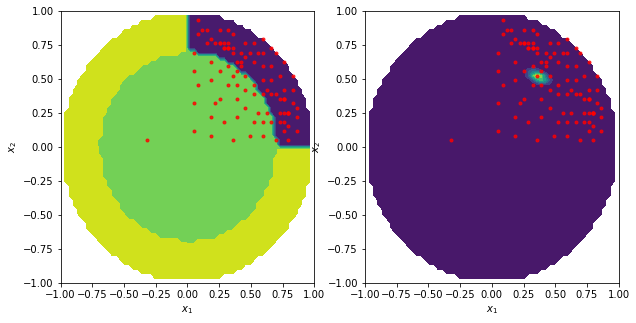

[ 343 1112 1287]
[1170  555  532]
[1752 1854  261]
[1157  610 1549]
[ 402  606 1208]
1
[1100 1350 1561]


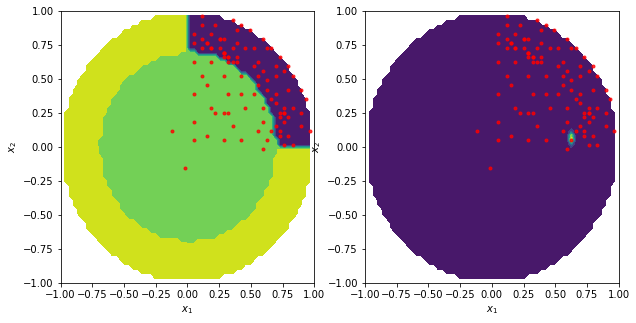

[1550 2229 2082]
[2009 1495 2194]
[ 588 1177 1323]
[1582 1215 2085]
[1158 1332 2178]
2
[1165  404 1848]


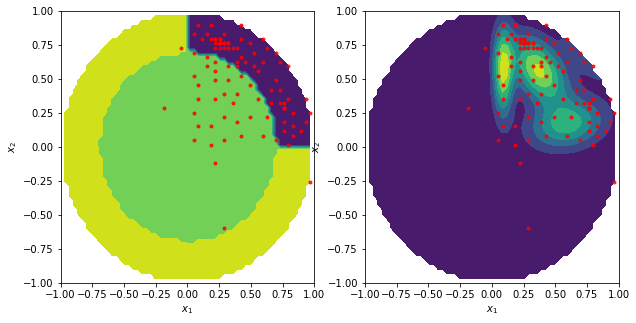

[1558 1270 1335]
[1668  823  928]
[1164 1551 2243]
[1090 1921 1234]
[1229  642 1340]
3
[1163 1912 1545]


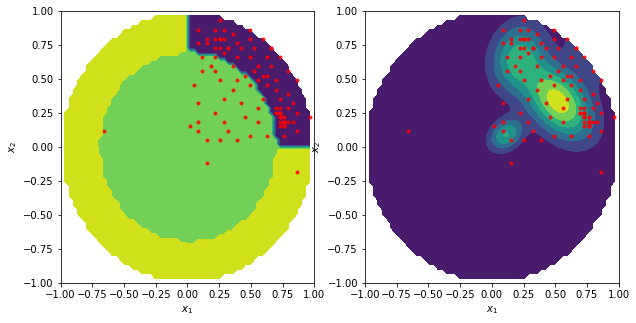

[ 353 2375  603]
[2272 1210 1556]
[ 452  484 1970]
[1683 1721 2289]
[ 341  876 1729]
4
[ 928  500 1229]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


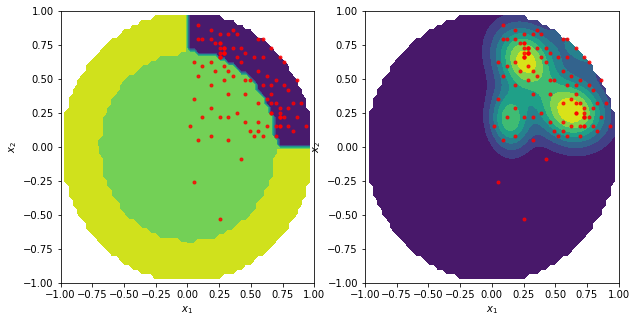

[2166 1786 2183]
[1865 2062 1285]
[1372 1857 1172]
[1678 2139 1690]
[ 708 2088  914]
5
[1379  809 1677]


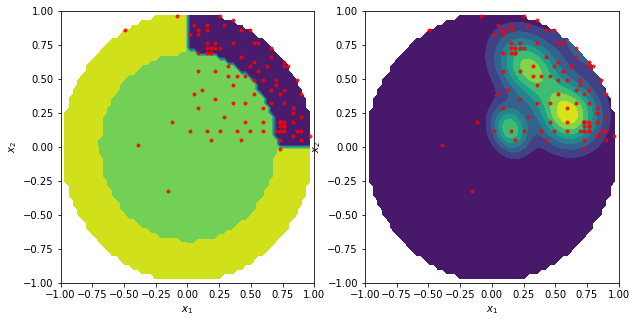

[1175  814 2018]
[1434 1143 1948]
[1699 1263 1469]
[ 585 2317 2133]
[ 703 1967  938]
6
[1525 1468 1841]


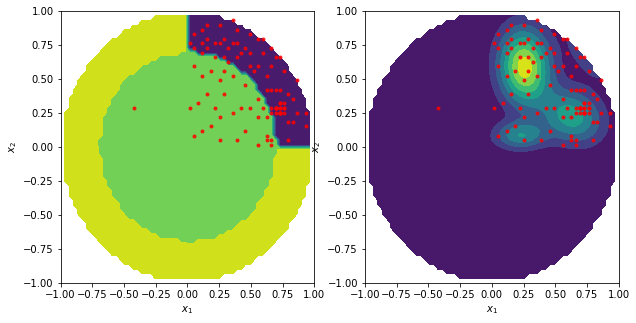

[1110 1157  873]
[1502 1409  604]
[ 719 1455 1902]
[2225  995  396]
[2225 2061 1960]
7
[1098 2183  718]


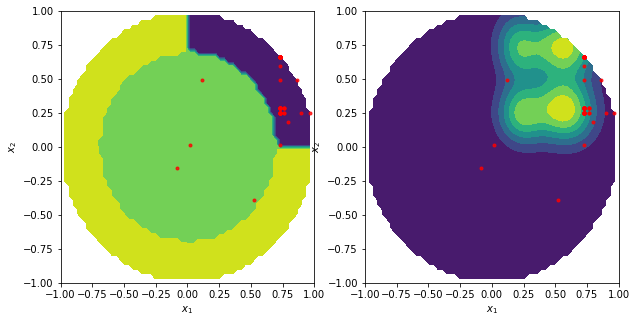

[1563  883 1963]
[1217 1084  663]
[2071 1430  716]
[1059  548  928]
[2079  880 1157]
8
[2062 1346 1959]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


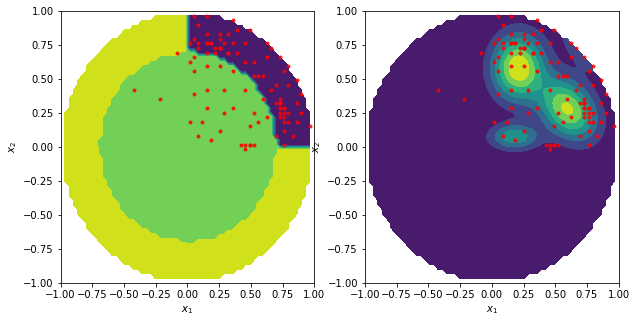

[2066 1909  581]
[2337 1905 1809]
[2190  603 1863]
[ 441 1033 1744]
[1290  745 1868]
9
[1498 1084 1751]


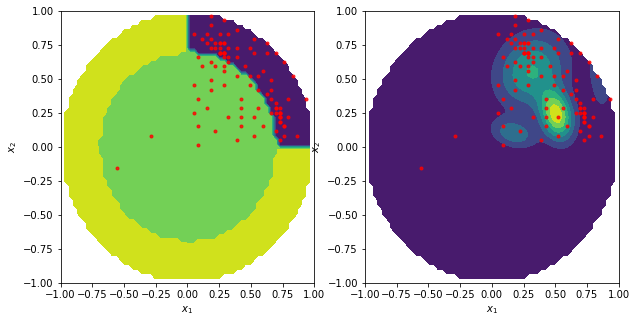

[ 702 2318 1603]
[1628 1663  913]
[2009 1294 1271]
[1617 2418 1171]
[2013  874  309]
10
[ 887 1273  550]


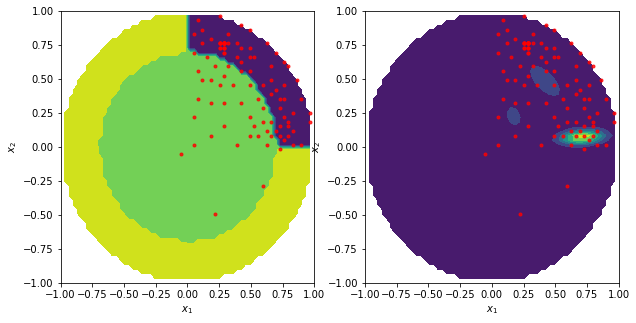

[1779 2034 1402]
[ 481  986 2120]
[1432 2326  557]
[1603 2174  752]
[1147  449  815]
11
[1571 1673 1902]


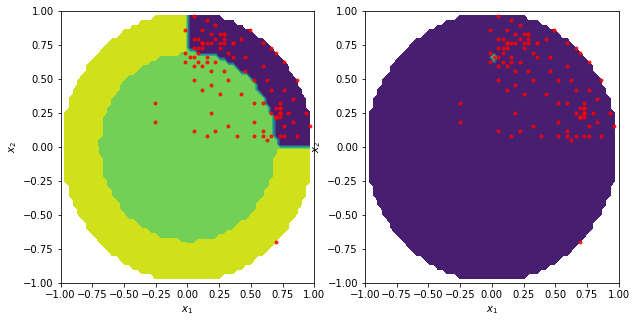

[1403 1733 1719]
[1056  648 1149]
[ 638 1409 1799]
[1032 1968 1458]
[1978  976 1209]
12
[ 976 1923 2010]


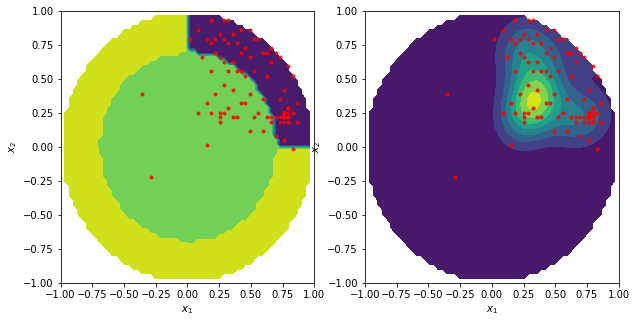

[1807  742 1913]
[ 943 2112 2272]
[2421 1794  809]
[1577  915  972]
[1139 1085 2323]
13
[1385 1114 1950]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


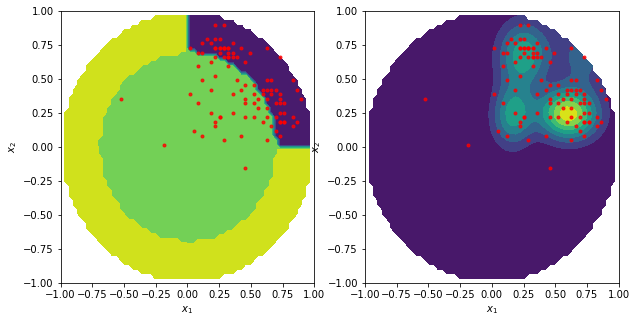

[2336  593 1115]
[658 486 762]
[1738  819 2369]
[1670 1326 1451]
[1663 1618 2084]
14
[1839 1051 1434]


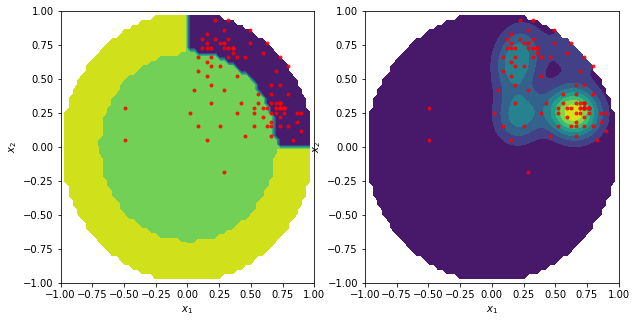

[1864 1336 1207]
[1952 1003 1798]
[ 925 2288 2380]
[1626 1566 2185]
[1282 1681 1685]
15
[ 396 1913 1576]


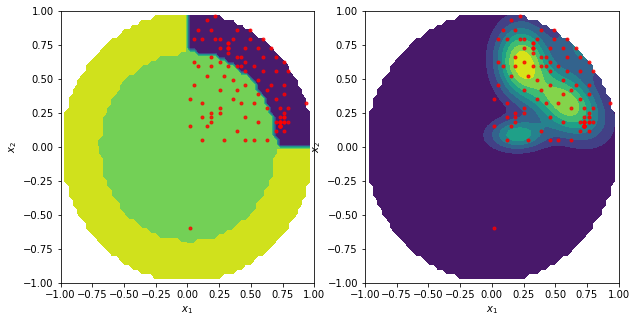

[1976  601  650]
[1106 1743 2133]
[ 773 1352  434]
[ 303  544 1198]
[1410 1812 1561]
16
[1582 2062 1454]


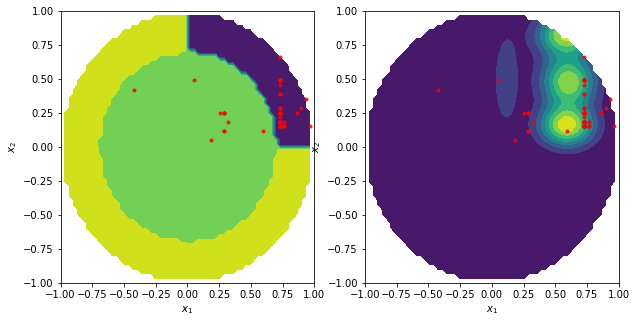

[1461  438  641]
[ 349 1106 2287]
[1739 1429 1752]
[2089  809 2334]
[1164  480 2319]
17
[ 916 2028  601]


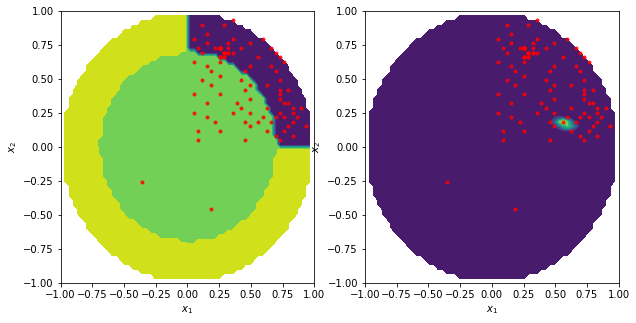

[ 495 1223 1851]
[ 812 1867 1618]
[1667 1319  636]
[1288 1176 1902]
[ 454 2126 1897]
18
[ 400 1397 1751]


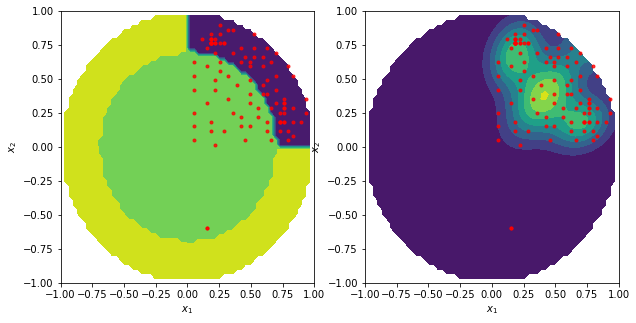

[1730 1676 1504]
[1279  442  744]
[1326  757  402]
[1207  261  987]
[2010 1801  992]
19
[1289 1677  709]


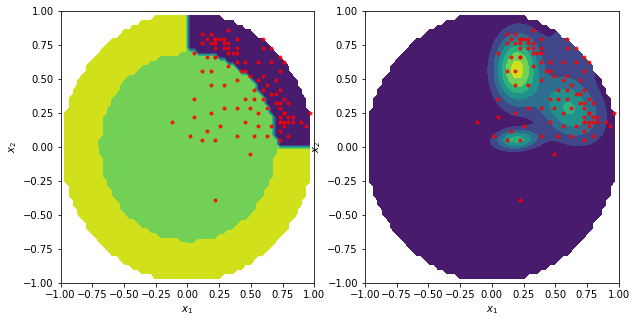

[931 590 884]
[1118  993 1398]
[1400  773  879]
[ 479  942 2005]
[1139 1810 2276]
20
[945 261 938]


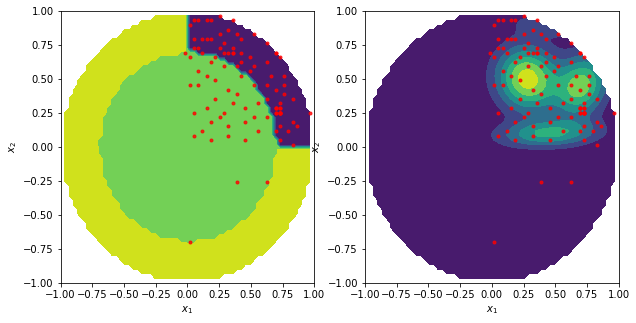

[2009 1731  868]
[933 918 854]
[2382  863  819]
[2377 1900  530]
[1894 1503 1552]
21
[1970 1565  653]


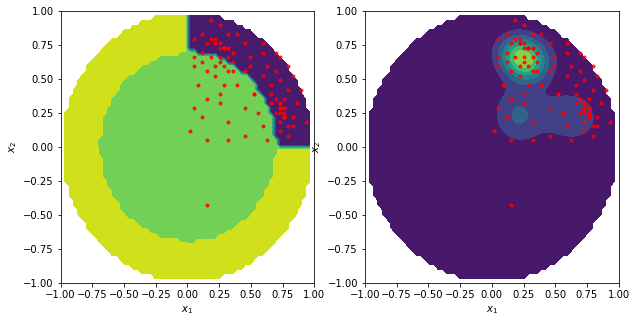

[ 658 1552  297]
[1149  987 1913]
[1346 2319  601]
[2062 1628 2326]
[1379 2419 1862]
22
[1096 1520  650]


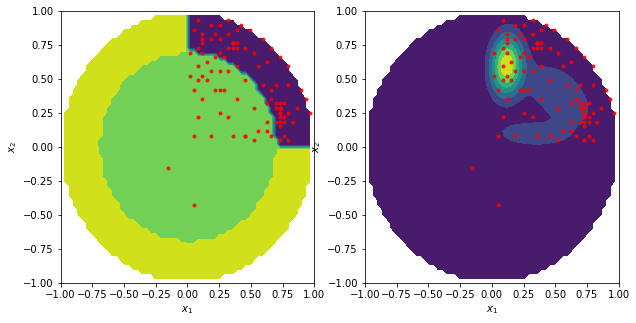

[2071 1317  880]
[2129  344  609]
[ 435 1375 1842]
[ 829 1058 2337]
[2141 2006  388]
23
[ 877 1783 1460]


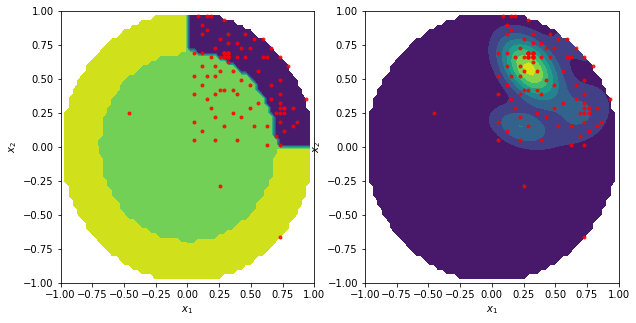

[ 611 2377 1456]
[ 975 2032  982]
[ 826  347 1665]
[1178  541 1198]
[1852 2026 1083]
24
[1102  767  916]


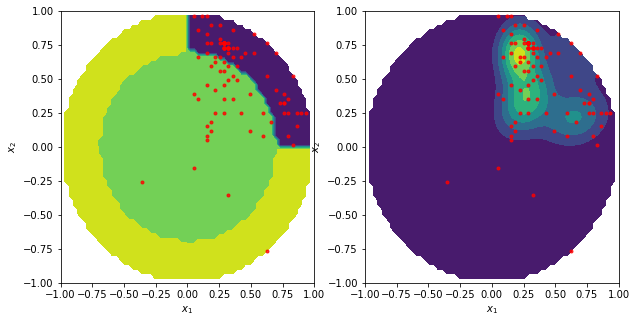

[1377  660  309]
[1694 1044  706]
[ 701 2127 1000]
[ 307 1804 1105]
[1553  824 1961]
25
[1313 2287 1638]


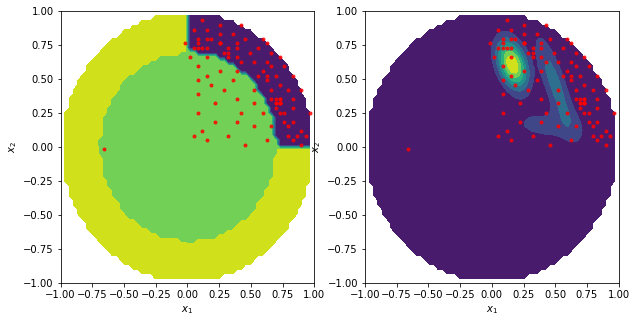

[ 660  499 1757]
[1909 1854 2020]
[2233  558 2234]
[1913 1223 1037]
[1143 1502 1584]
26
[2426 1952 2464]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


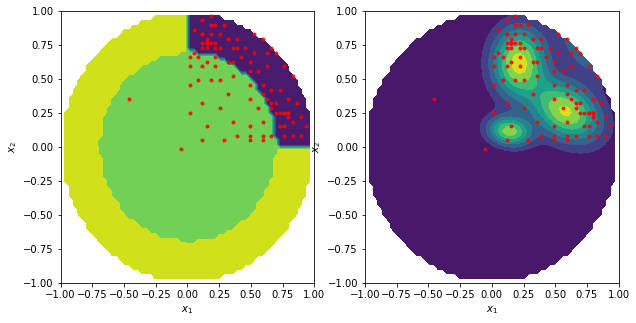

[1501 2017  932]
[1581 1622 1346]
[1682  391 1628]
[ 918 1632 1374]
[ 534  601 1670]
27
[ 768 2171 1733]


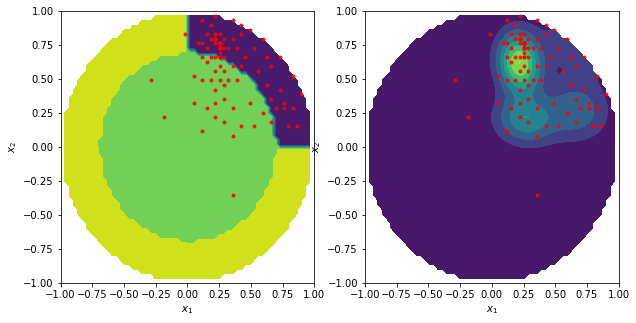

[ 995 1802  453]
[ 646 1198  340]
[ 803 1745  741]
[1902 1857  554]
[1396 1347 1290]
28
[1029 2127 1328]


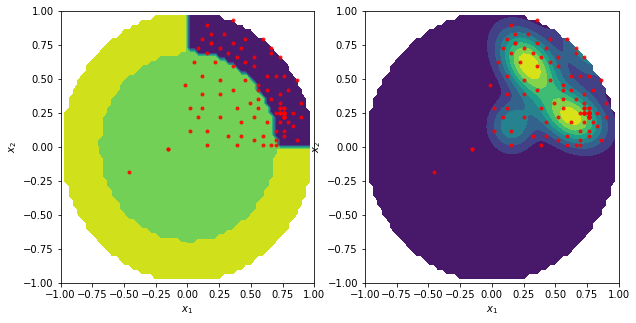

[1167 2168 2366]
[2325 1052  584]
[1637 1500  592]
[1901  650 1441]
[2269 1386 1148]
29
[2016 1737 1205]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


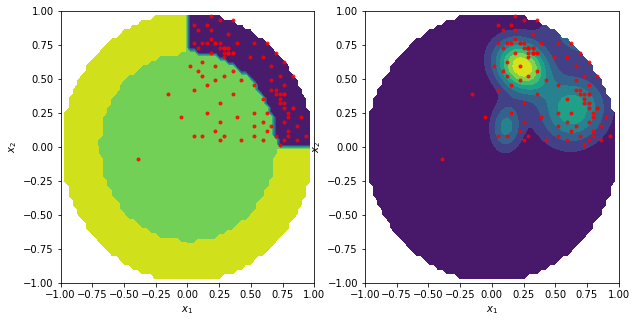

[1171  818  302]
[ 992  815 1035]
[ 645 1389  919]
[ 937 1507 1283]
[1397 1611 2183]
30
[1981 1525  634]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


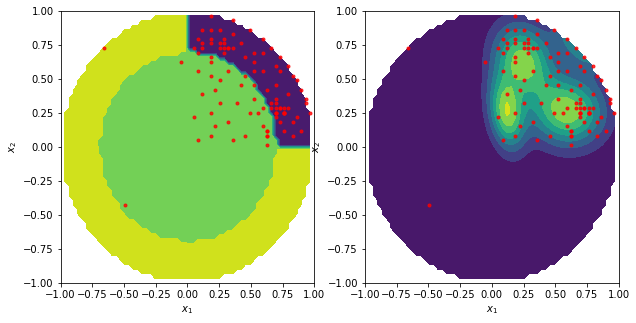

[ 917 1606 2372]
[2370  708  939]
[1388 1788 1558]
[1916 1259 1171]
[ 538 2172  501]
31
[ 260  656 1093]


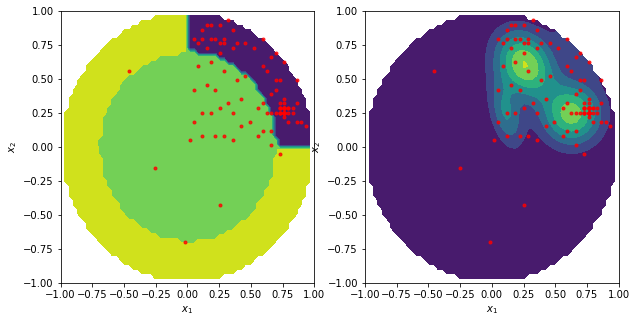

[1628  300 1547]
[2020 2022 2223]
[1730  770 1917]
[2231 2222  706]
[ 980  538 1172]
32
[1391 1336  558]


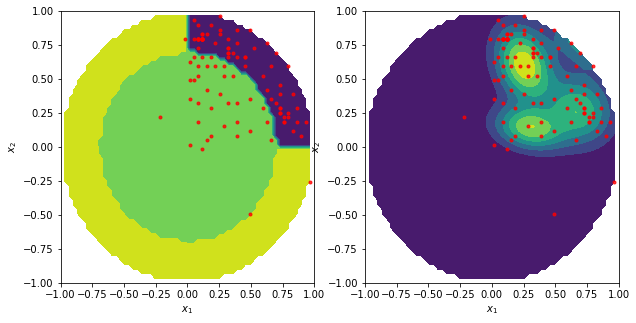

[1277 1550 1507]
[1841 1350 2175]
[1152 1836  761]
[ 532 2221 1394]
[748 918 702]
33
[1451 1694 1756]


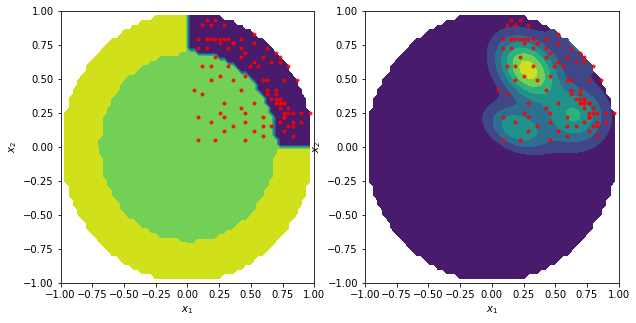

[ 349 1335 2219]
[1288 2424 1229]
[2336 1259 1271]
[ 552 2222  828]
[1525 1165 1779]
34
[2325 2318 2273]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


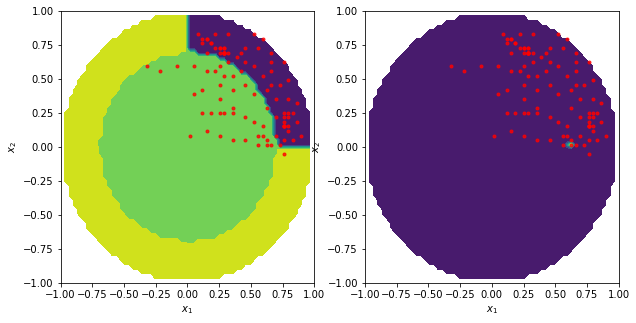

[1752 1402 1974]
[1550 1226 1508]
[ 929 1784 1728]
[1095 1584  913]
[ 662 1258 1497]
35
[ 813 2281  529]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


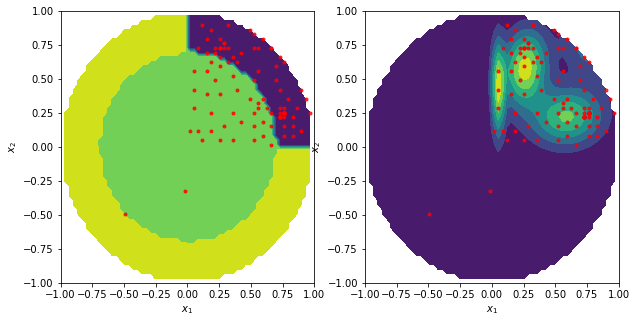

[2124 2009 2334]
[2328 1583 2169]
[2289 1835  711]
[1172 1810 1634]
[1285  877 2078]
36
[1802 1562  664]


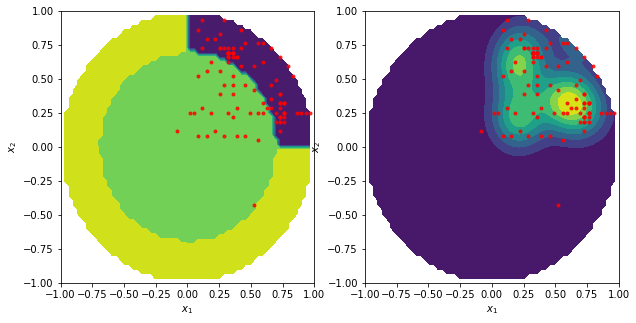

[1733 1081  754]
[1949 1750 2269]
[ 499  805 1374]
[ 717 1032 1464]
[1918 1334 1318]
37
[1635 1796  812]


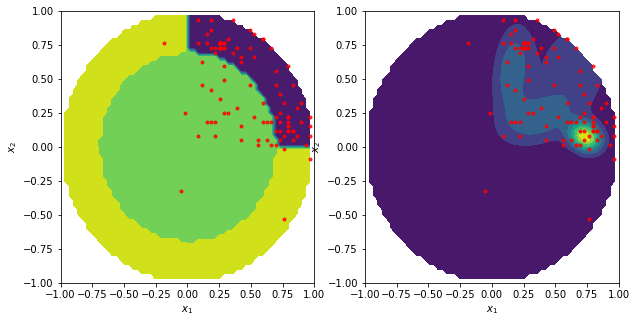

[ 820  582 1277]
[ 856 1213  535]
[2335 1389 1631]
[1316  968  882]
[ 611 1547 2368]
38
[ 943 2066 2123]


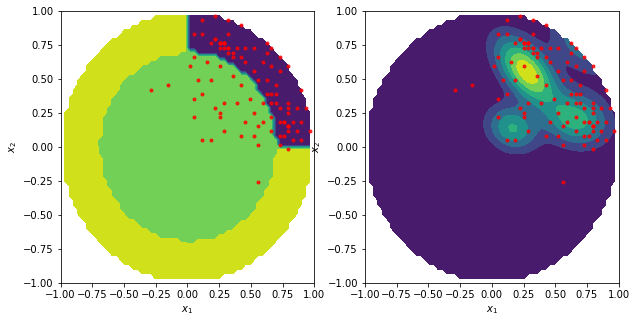

[ 436 1313 2235]
[2188  533 1166]
[1329  345 1604]
[2463 1062 2184]
[2366  934 1334]
39
[ 557 1031  355]


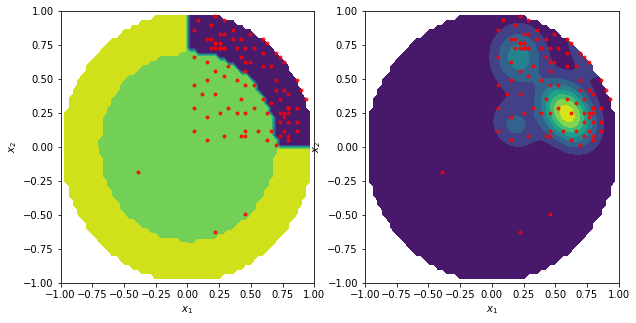

[ 444 1642 1204]
[1799 1983 1788]
[1847 1906  451]
[1584 1199  444]
[2238 2127 1780]
40
[1578  763 1841]


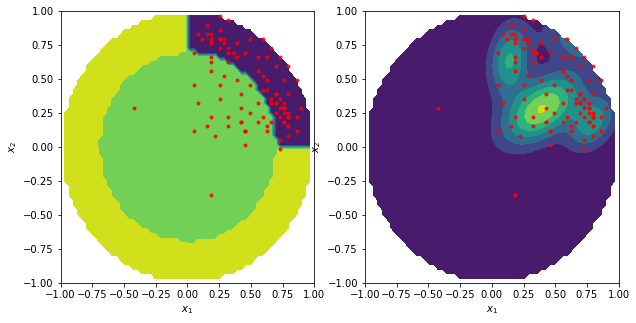

[1634 2284  978]
[ 928 1853 1907]
[1571  597  701]
[2010 1690  440]
[1388  658 1323]
41
[1004  355  768]


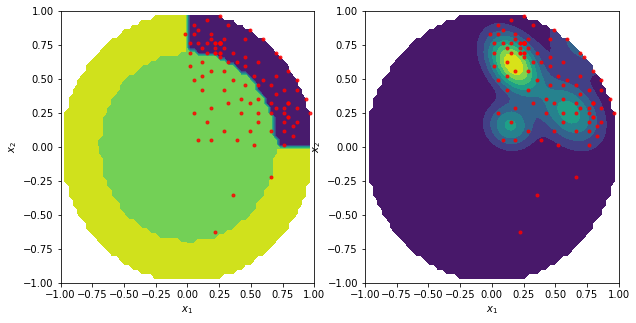

[ 821 1023 2118]
[1226  772 2020]
[1380  641 1090]
[1028  945 1862]
[2074 2024 1740]
42
[1518  546 1384]


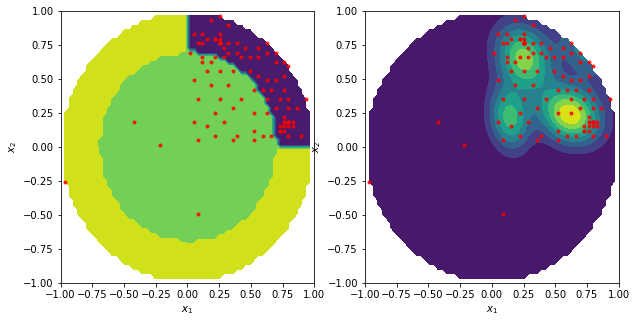

[1059 1314  551]
[2130 1808 2007]
[2278 1619 1443]
[1119 1678 1058]
[ 651 2279  882]
43
[1615 1175 1232]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


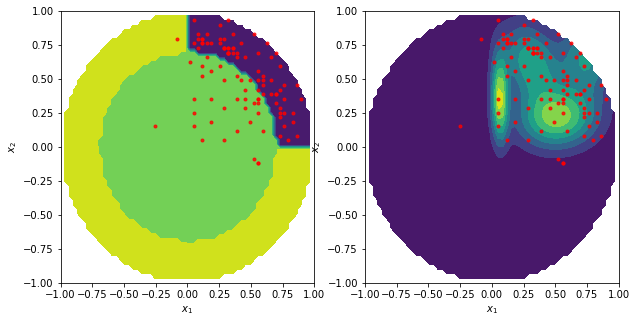

[1640  712  441]
[ 640 1116 2010]
[ 873 2236  652]
[1572 1558 1216]
[ 454 1977 1199]
44
[1175  437 1634]


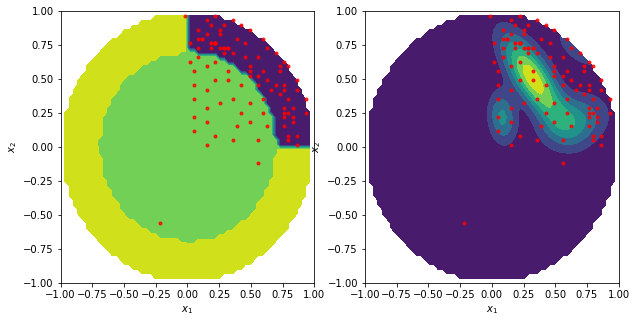

[1204  346 2033]
[ 531 1668  938]
[1699 1050 1449]
[2325 1455 1109]
[ 909 1115  385]
45
[ 611  965 1160]


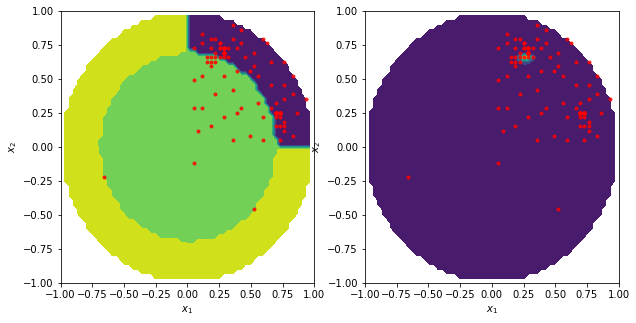

[1384 1789 1004]
[ 814  545 1149]
[1274 2171  554]
[2324 1729 1811]
[ 399 1860 1330]
46
[1234 1731  703]


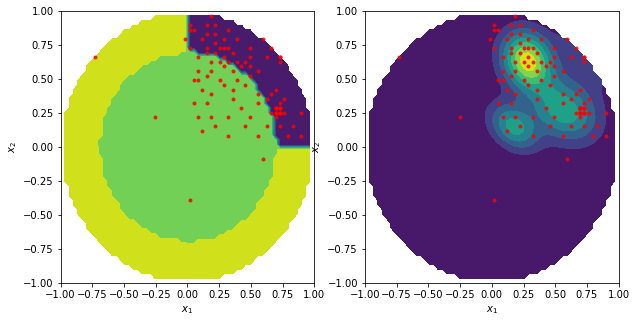

[1265 1210  910]
[2463 2063 1205]
[1740 1565  978]
[1513  537  796]
[1315  593  876]
47
[ 870 1277 1206]


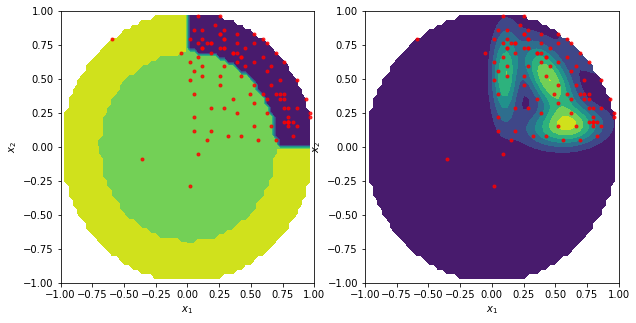

[1027 1166  655]
[ 663  708 2426]
[ 480  942 2322]
[ 925 1892 2282]
[1849 1433 2285]
48
[1981  504 1846]


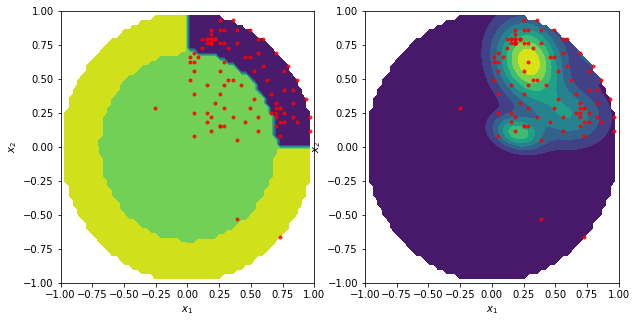

[1025 2165 1388]
[1547 2368 1385]
[ 532  827 2377]
[ 695 2280 2167]
[1349 1338 1000]
49
[1981  349  392]


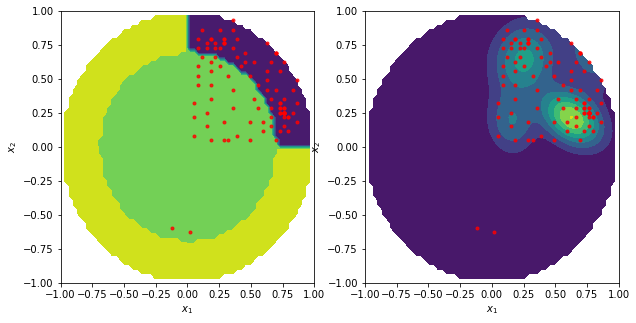

[ 934 2116 1840]
[1870  531 2244]
[1757  392 2282]
[1583 1272 1411]
[ 394 1163 1219]
50
[1159  596 1625]


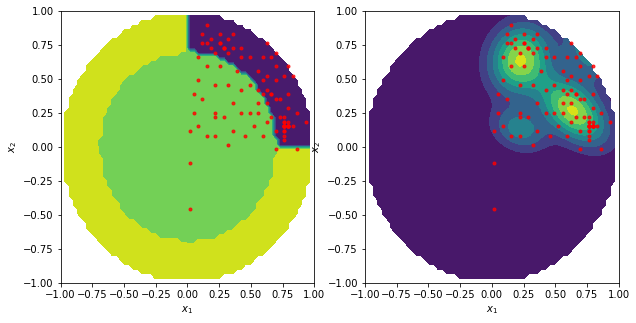

[1927  300 1081]
[2031 1912 2035]
[350 860 404]
[1927  766 1501]
[ 917 1640 2338]
51
[ 740  637 1980]


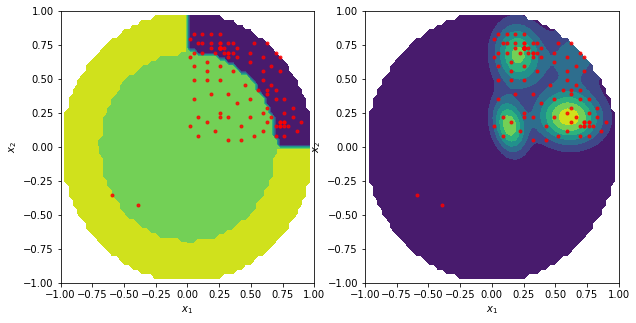

[824 797 557]
[ 973 1663 2217]
[2167 1198 1959]
[1813 1636 1740]
[2244 1797  556]
52
[1836  297  874]


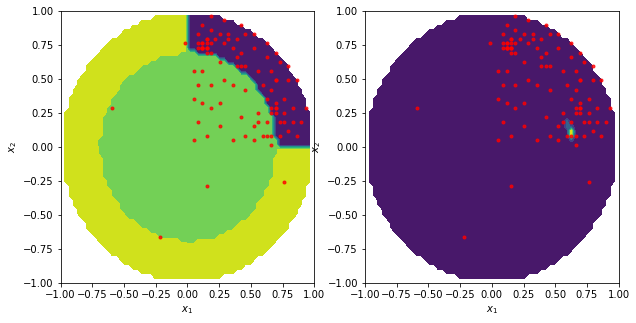

[ 663 2006 1439]
[1956 1428 1053]
[1751  977 1429]
[1983  713 1676]
[1254  864 2024]
53
[2219 1522 1390]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


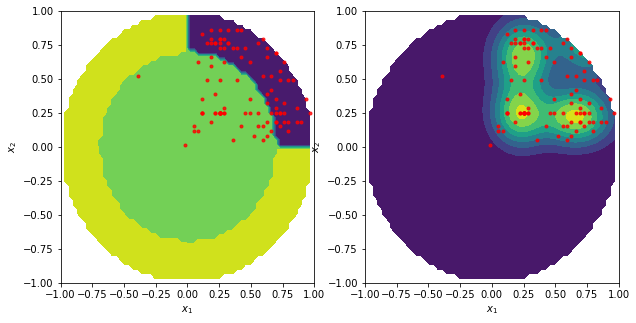

[ 398 1735  977]
[2167 1451 2232]
[ 650 1642 1024]
[ 701  919 1262]
[1201 2369 2137]
54
[1791 1376 1140]


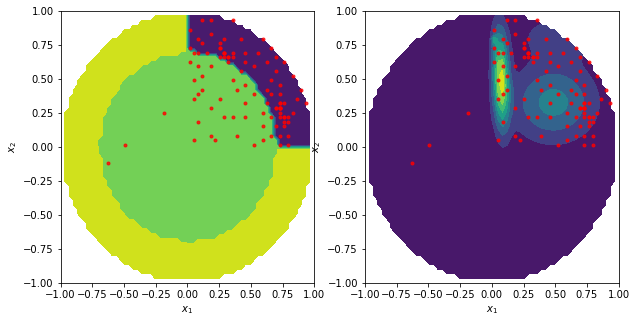

[ 975 1058 1165]
[ 639 2017 2136]
[2182 1431  489]
[1903 1505  937]
[2124 1791 1623]
55
[2236 1273 1288]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


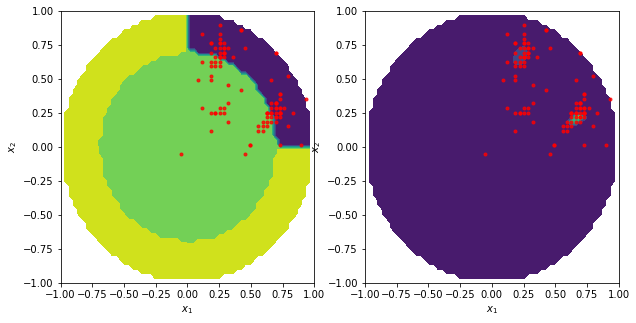

[ 547 1452 1567]
[1732 1204 1218]
[ 829 1859 1734]
[1497  594 1696]
[ 811 1499 2334]
56
[ 914 1114  742]


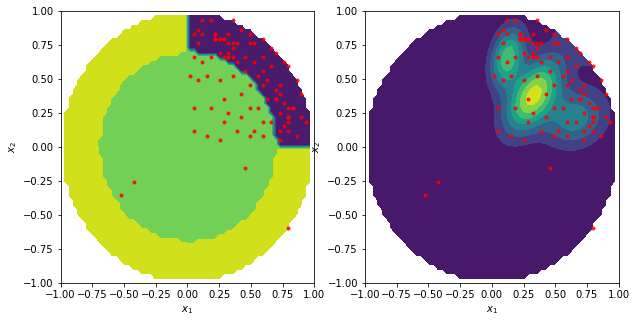

[2331  483  803]
[2033 2026  926]
[1390 1339 1863]
[2114 1003  851]
[1796  912 1031]
57
[2240 2065 2221]


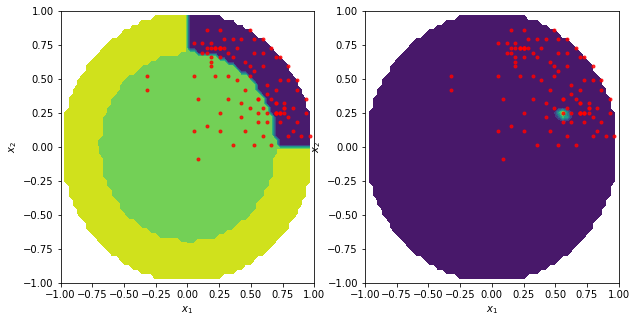

[2269 1788 1294]
[2029 2283 1923]
[2272 2270 1633]
[2016 1900 1106]
[965 658 817]
58
[1631  529 1523]


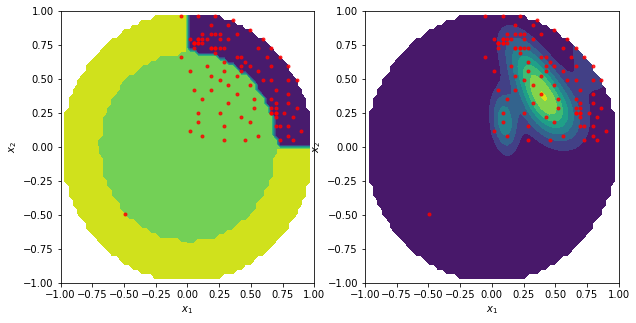

[1385 2027 1732]
[ 436 1807 2239]
[1198 1677 1964]
[ 351 1405 1912]
[ 500  480 1855]
59
[ 821 1326 2077]


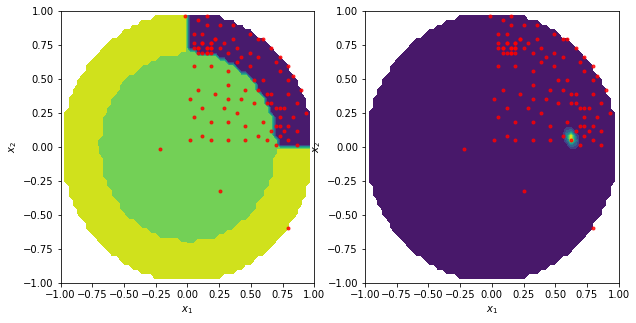

[ 690 2234 1853]
[ 755  452 1727]
[ 945 1340  815]
[2034 1233 1853]
[2027 1450 1498]
60
[ 717 2090  742]


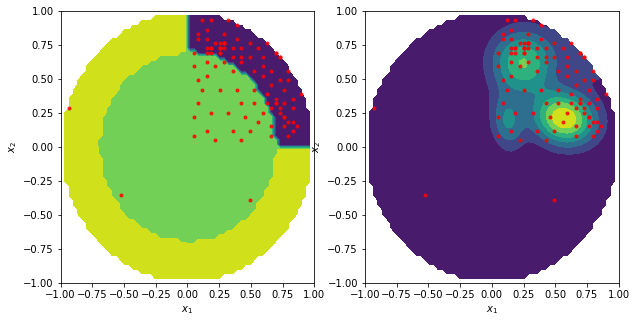

[1561  918 1782]
[1433 2133 1167]
[2233 2235 1671]
[1746 1578 1618]
[ 433 1024 1495]
61
[ 587 2027 1337]


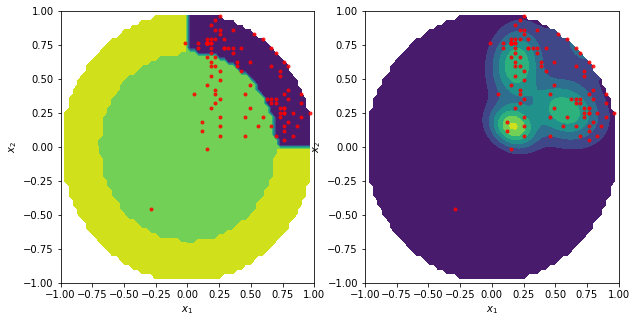

[2139  702  588]
[1059 2062 2033]
[ 533 1162  809]
[1897  489 2219]
[ 874 1172  262]
62
[2010 2035  746]


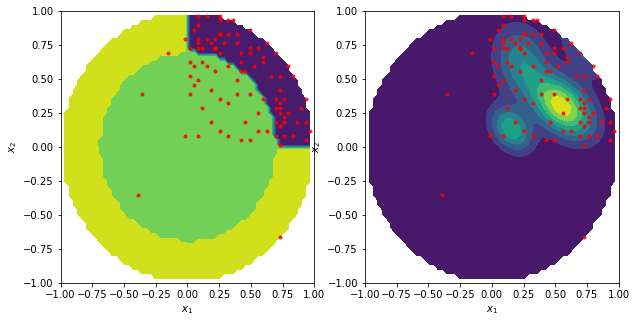

[1691 2022  346]
[1156 2030 2367]
[ 800 1226 1389]
[1958 2374 1024]
[1672 1030 1380]
63
[2138 1197  801]


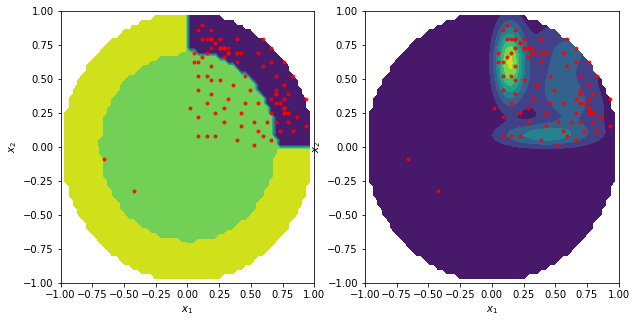

[ 502 1160  941]
[1030 2379 1325]
[1323  996 1860]
[1558 1279  489]
[1865 1086  936]
64
[1204 1029 1524]


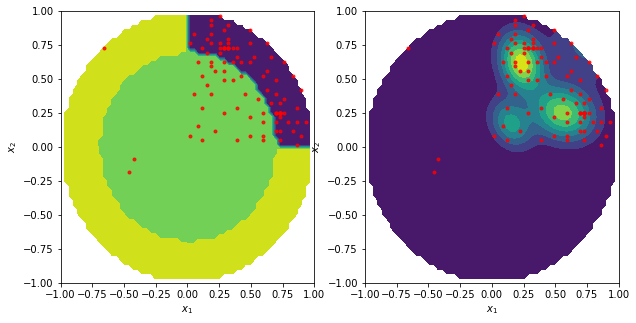

[2013 1394 1370]
[1234 1275  584]
[ 695 1799  593]
[1160 1512 1042]
[1319 1223  822]
65
[1440 1576  763]


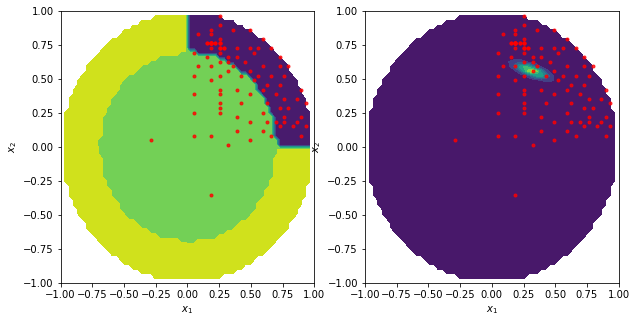

[1556 2185 1625]
[ 609 1491  814]
[2126 1329 1090]
[ 598 1953  752]
[ 691  870 2220]
66
[ 481 1213  705]


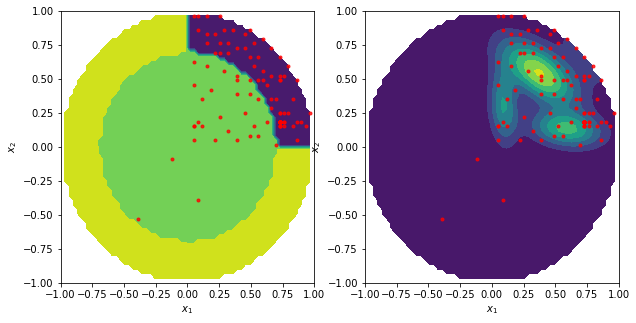

[773 598 585]
[829 449 812]
[1523 1333 1103]
[2128 2060 2291]
[1498  648  808]
67
[1452 1635 2379]


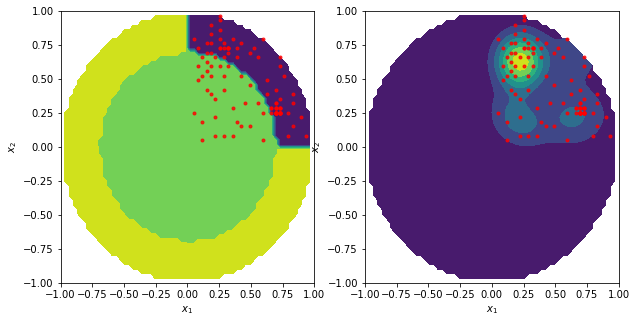

[2379  807 1785]
[2461 1794  402]
[2143 2021 1559]
[ 536  915 1117]
[2276  352  701]
68
[1498 1757  594]


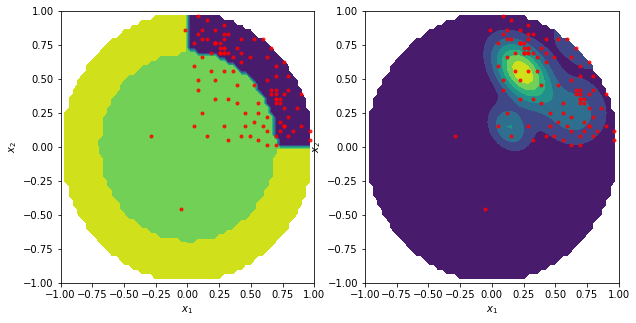

[2317 1505  310]
[ 303 1029  774]
[2379 1614 2270]
[1158  873 1622]
[1920 1089  590]
69
[ 437 2242 1507]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


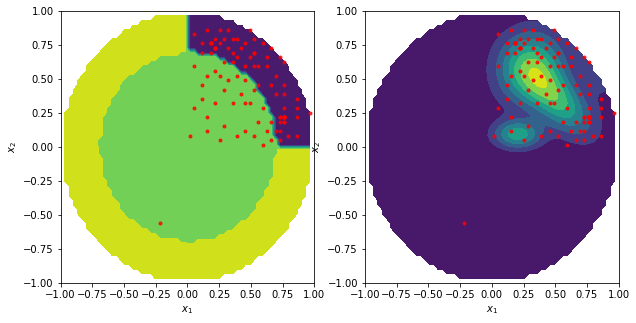

[ 921 1215 2280]
[ 873 1450 1623]
[1745 1811  297]
[ 865  691 1796]
[2171 1618 1377]
70
[1313  978 1629]


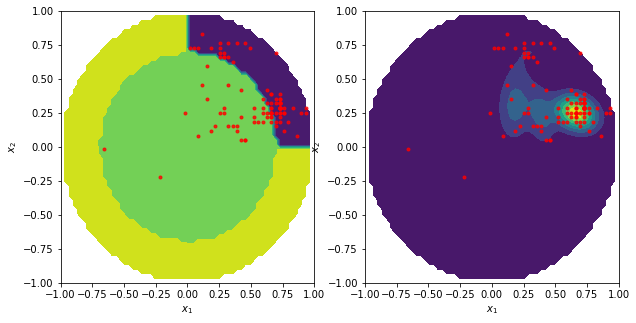

[1333  748 1803]
[1257 1034 2329]
[ 820 1801 2171]
[ 965 1636 1848]
[1570  601 1083]
71
[1808 1950 2320]


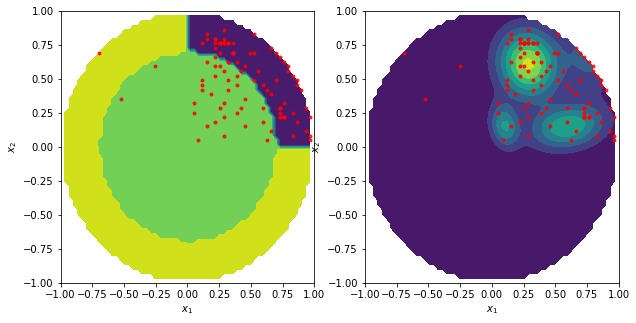

[1924 1676 1113]
[ 851  940 1149]
[1153 1402 1700]
[ 538 1432 1323]
[1374 2377 1400]
72
[ 990 1496 1609]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


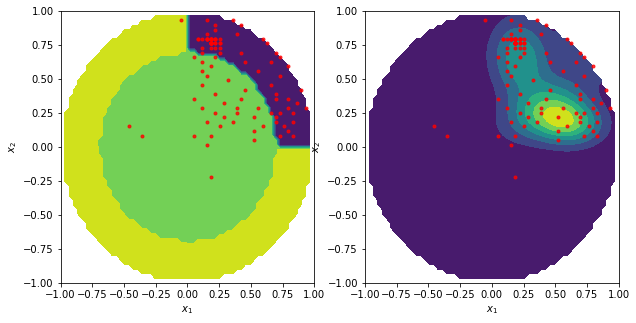

[ 830 1280 1351]
[1109 1491  587]
[2374 1440 1503]
[ 862 1373  713]
[1675 1570 1510]
73
[747 550 587]


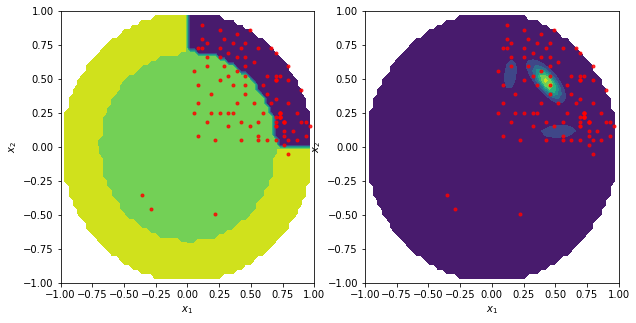

[1982  661 1797]
[2277 2112  534]
[ 498 1218 1867]
[ 708 1792 1410]
[1350 1728 1405]
74
[2286 1804 2335]


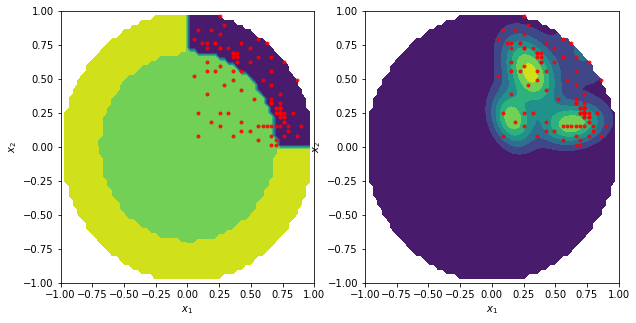

[ 447 2075 1815]
[2421 2125  865]
[1612  532  595]
[1756 2178 1460]
[1390 1097 2381]
75
[1685 1324  938]


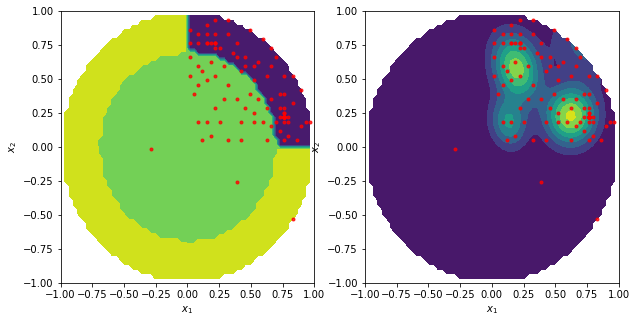

[1797 2020 1409]
[1160 1259  933]
[2084 2066  798]
[2241  996 2287]
[2035 1698 1091]
76
[2115 2275  605]


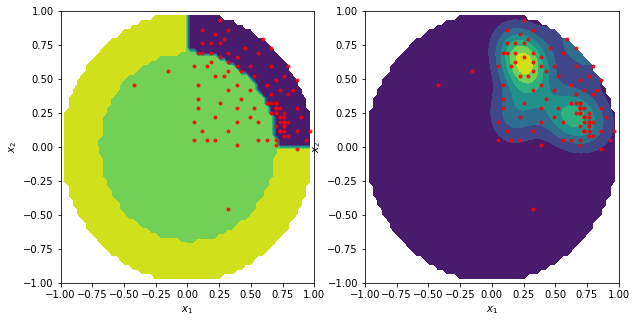

[1897 1038  307]
[2419 1285 1290]
[707 609 700]
[ 692 1907  876]
[1324 1859 2230]
77
[1496 1261 1733]


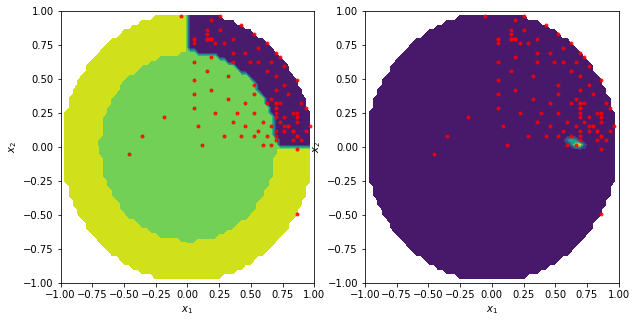

[ 448 1557 2240]
[ 967  706 2290]
[2194 1899 1294]
[1520 2116  866]
[ 748  868 1813]
78
[ 869 1843  970]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


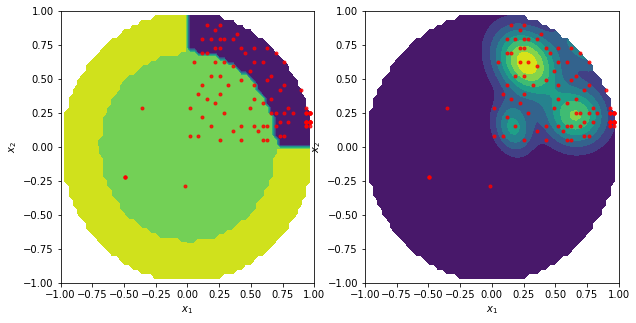

[1198  454 1446]
[1226  655 1901]
[ 493  698 2290]
[1038 1212  750]
[1331  554  609]
79
[1295 1721  504]


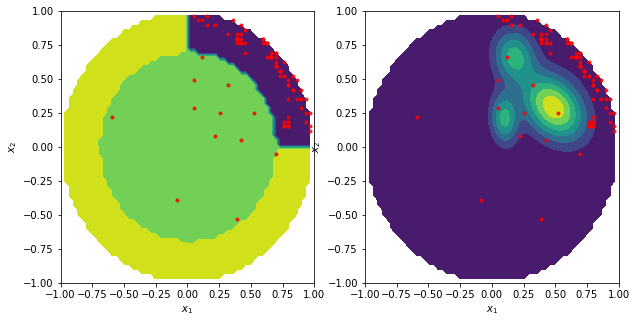

[ 662 1955  438]
[1320 1964 2027]
[1435 2023 1406]
[2020 1923 2283]
[1506 2319 1642]
80
[1091  401 1278]


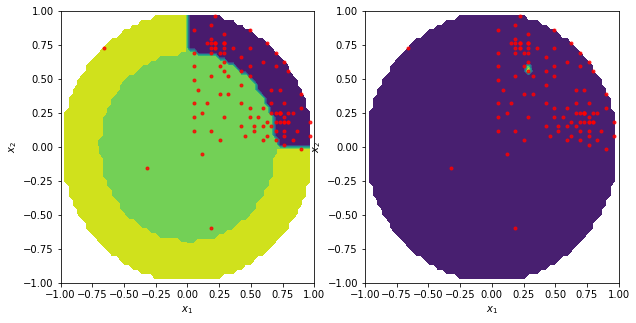

[1396 1801 2060]
[1454 1669  450]
[ 860 1976  660]
[806 605 942]
[ 968  914 1899]
81
[ 492  659 2322]


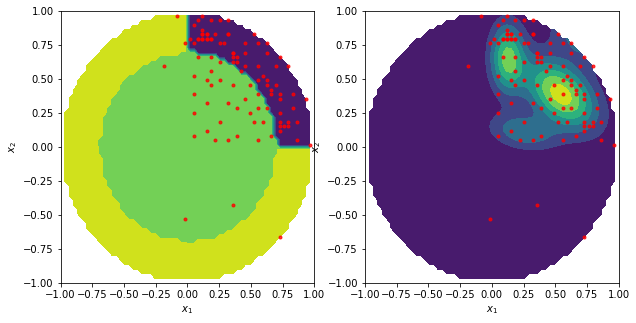

[1312 1404 2223]
[1726 2375 2128]
[ 593  496 1662]
[ 386 2171 1292]
[2180 2230 1441]
82
[ 662 2089 2179]


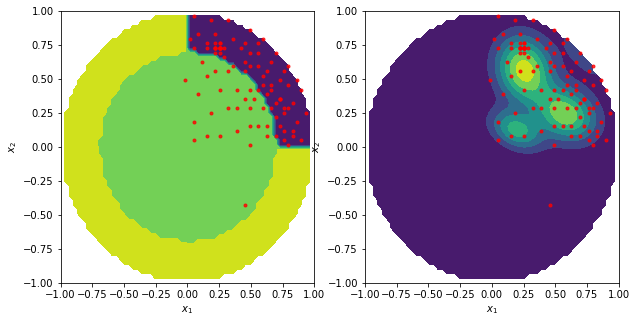

[ 558 1381 1466]
[ 479 2083  502]
[828 657 602]
[2285  601  988]
[1099 1983 2175]
83
[ 608 1556  996]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


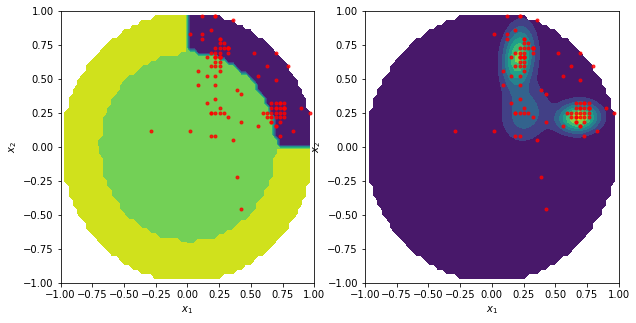

[772 694 987]
[1560 1551  995]
[ 495  581 2374]
[444 636 487]
[2335  699 2135]
84
[1498 1432 1783]


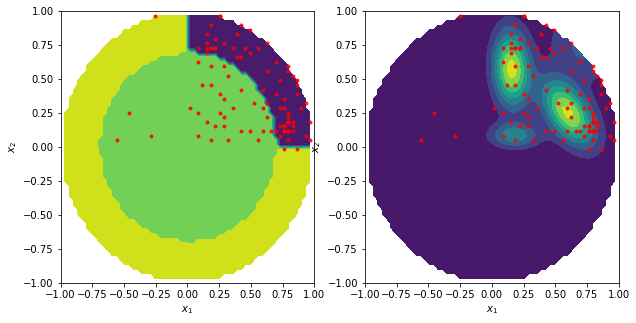

[1434 1675 1375]
[ 481 1226 1331]
[2332  584 2062]
[1465 1518 1466]
[1914  603  979]
85
[1216 1684 1551]


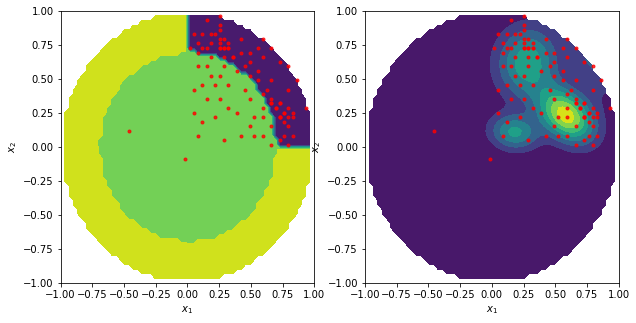

[ 817  355 2128]
[2178 1786 1314]
[ 693 1171 1743]
[1782 2194  546]
[1294  385 1338]
86
[1749 2332 1555]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


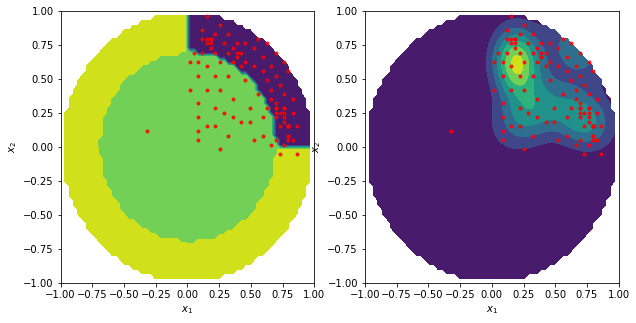

[ 649 1680  340]
[2424  987  638]
[ 447 2185  878]
[1802 1699  748]
[1407 2272 1745]
87
[1049 1158 1112]


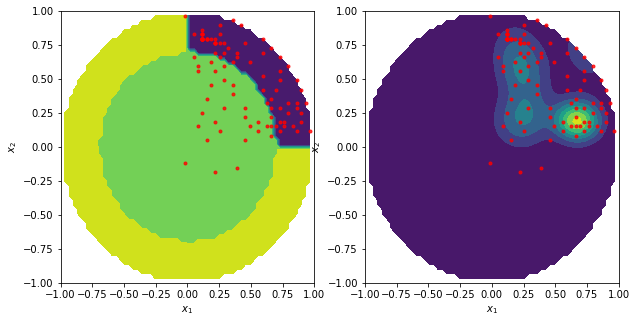

[ 968  941 2223]
[1431 1081 2184]
[2142  827 1207]
[1623 1216 2415]
[ 506  987 1055]
88
[1047  762  405]


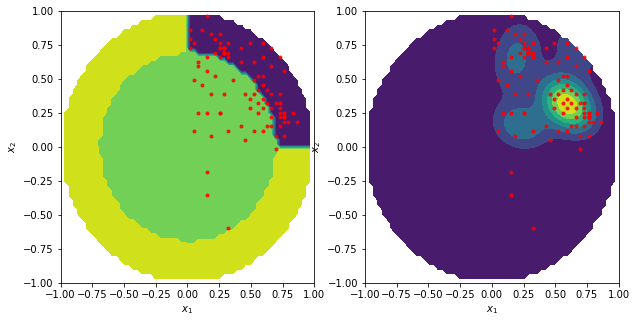

[1255 1608  750]
[1556 1673 2067]
[ 710  261 2004]
[2236 1754  499]
[1447  699 1745]
89
[1502  873 2186]


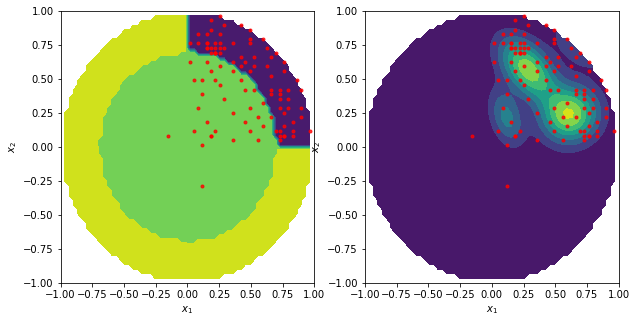

[1641 1565  544]
[ 915 1664 1267]
[ 433 1118 1287]
[2238  347 1102]
[2369 2326  446]
90
[1737 1273 1081]


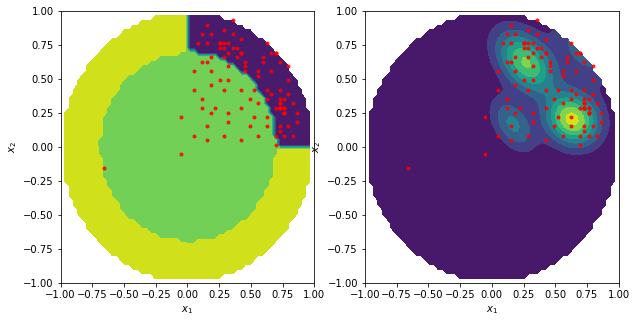

[ 604 1855 1605]
[2175 2089  938]
[1864  942  664]
[2086 1523 1691]
[2088 2377  884]
91
[ 491 2113 1391]


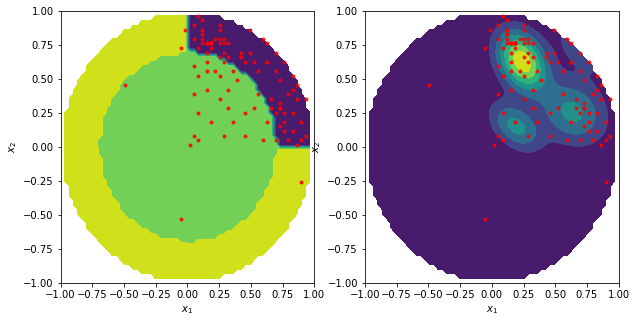

[2337 1291 1726]
[1469 1571 2371]
[1288 1269  885]
[1142 2177 2005]
[2236  912 2187]
92
[ 859 2079 2320]


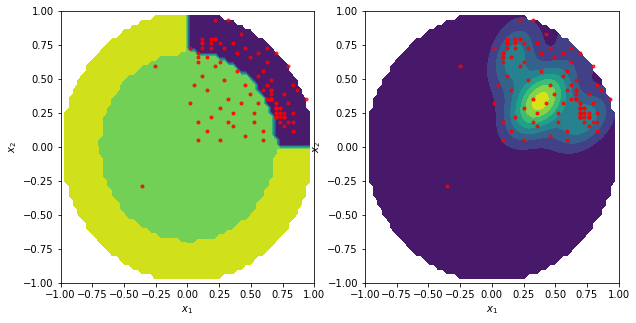

[1662 2283 2382]
[ 397 1682 2419]
[ 929  347 2118]
[2291 1670  915]
[1451  853 1279]
93
[ 260  990 1086]


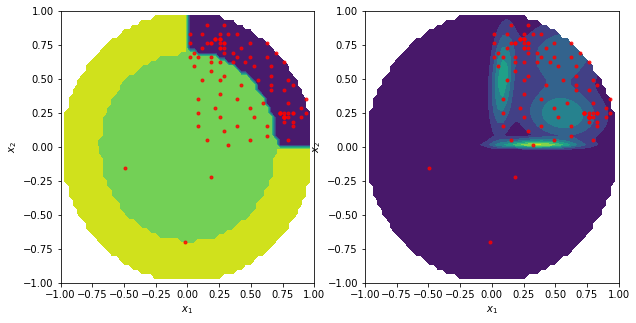

[1582 1398 1903]
[ 537 1872 1402]
[ 549 1119 1574]
[1158 1674 2334]
[698 588 877]
94
[1721 1564  352]


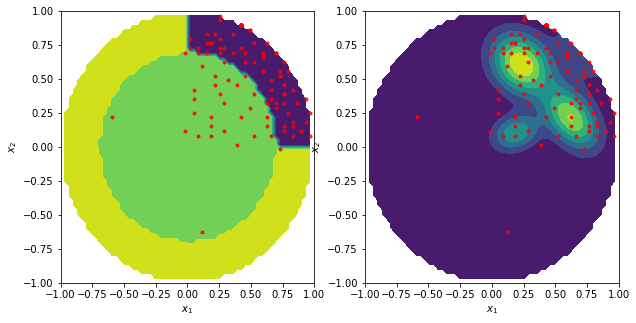

[2379 2085 1372]
[1040 1042 1173]
[1961  766 1673]
[1164 1694 2065]
[1497 1387  404]
95
[ 702 1778  347]


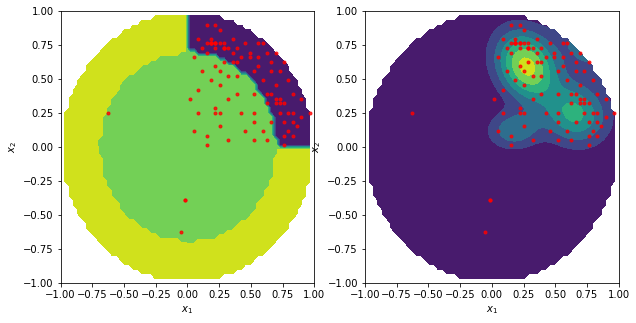

[ 548 1626 1968]
[1793 2130 1927]
[1460 1331 2029]
[1790 1858 2374]
[1948 1219 2171]
96
[1446 1000 1867]


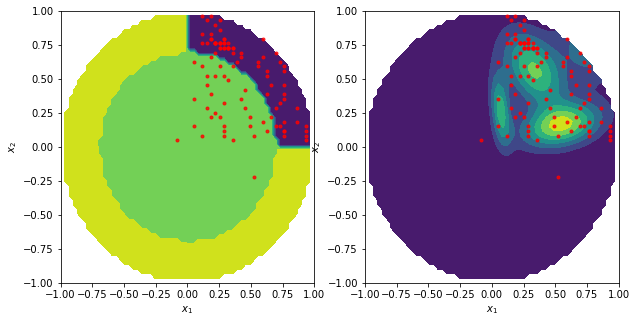

[1896 1620 1169]
[1038  551  857]
[ 404 1031 1684]
[ 931 2417 1521]
[1901 1903  594]
97
[1919 1163  654]


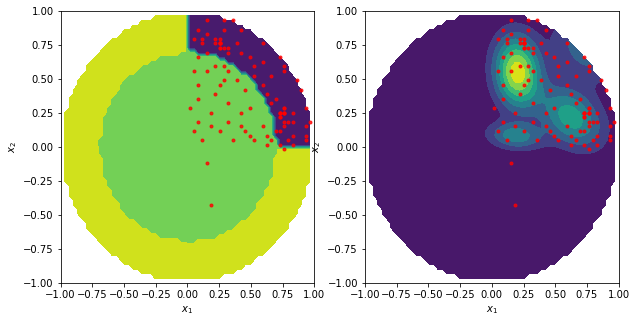

[1572 1954 1102]
[1272 2026  391]
[1381 2129 1758]
[ 541  775 1334]
[1404 1271  917]
98
[2270  534 2028]


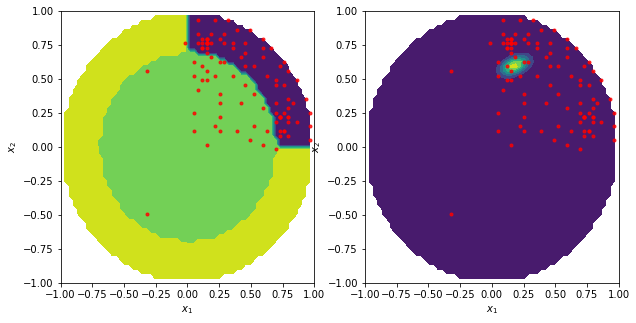

[2081 1274 1666]
[1679 1691 1627]
[ 449 2240 1558]
[ 594 1199  443]
[ 943 1922 1341]
99
[1952 1346  940]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


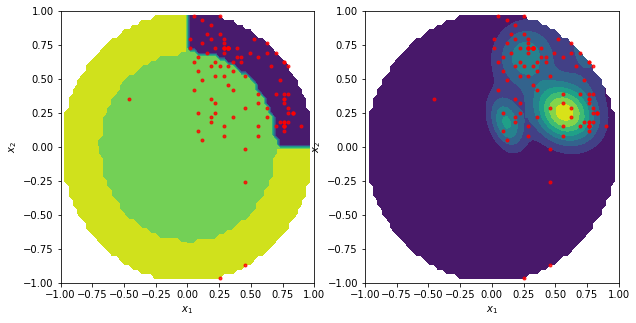

[1148 2126  881]
[1508 1226 1466]
[1526 1091  929]
[2284 1962 1754]
[1285 2291 1381]
(100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 60, 60)


In [5]:
model = run_simulations(Y_data, xs, sigma, T, MC_samples, XX, YY, Y_data_plot, nn, delta_control)
regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB = model.train()

np.save("regrets_LCB", regrets_LCB)
np.save("regrets_LCB_v", regrets_LCB_v)
np.save("regrets_mean", regrets_mean)
np.save("regrets_TS", regrets_TS)
np.save("regrets_EI", regrets_EI)
np.save("regrets_LW_LCB", regrets_LW_LCB)

np.save("X_LCB", X_LCB)
np.save("X_LCB_v", X_LCB_v)
np.save("X_mean", X_mean)
np.save("X_TS", X_TS)
np.save("X_EI", X_EI)
np.save("X_LW_LCB", X_LW_LCB)

np.save("Weights_LW_LCB", Weights_LW_LCB)




